In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from collections import defaultdict
from wordcloud import WordCloud
import nltk
import spacy
from nltk.stem import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import pickle
import kaggle
from zipfile import ZipFile
import warnings
warnings.filterwarnings("ignore")

In [2]:
# !kaggle datasets download -d hernan4444/anime-recommendation-database-2020

In [3]:
# file_name = r'anime-recommendation-database-2020.zip'
# with ZipFile(file_name, 'r') as zip:
#     zip.extractall()
#     print('Done')

In [4]:
# Anime data
columns = ['MAL_ID', 'Name', 'Genres', 'Type', 'Type', 'Aired', 'Premiered', 'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating', 'Popularity', 'Score', 'Episodes']
anime_data = pd.read_csv('anime.csv', usecols=columns)
# Synopsis data
synopsis = pd.read_csv('anime_with_synopsis.csv')

In [5]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MAL_ID      17562 non-null  int64 
 1   Name        17562 non-null  object
 2   Score       17562 non-null  object
 3   Genres      17562 non-null  object
 4   Type        17562 non-null  object
 5   Episodes    17562 non-null  object
 6   Aired       17562 non-null  object
 7   Premiered   17562 non-null  object
 8   Producers   17562 non-null  object
 9   Licensors   17562 non-null  object
 10  Studios     17562 non-null  object
 11  Source      17562 non-null  object
 12  Duration    17562 non-null  object
 13  Rating      17562 non-null  object
 14  Popularity  17562 non-null  int64 
dtypes: int64(2), object(13)
memory usage: 2.0+ MB


In [6]:
synopsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MAL_ID     16214 non-null  int64 
 1   Name       16214 non-null  object
 2   Score      16214 non-null  object
 3   Genres     16214 non-null  object
 4   sypnopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


In [7]:
anime_data = anime_data[anime_data['Type'] == 'TV']

full_anime_data = anime_data.merge(synopsis)
full_anime_data = full_anime_data.rename(columns={'sypnopsis': 'Synopsis'})

In [8]:
full_anime_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4996 entries, 0 to 4995
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MAL_ID      4996 non-null   int64 
 1   Name        4996 non-null   object
 2   Score       4996 non-null   object
 3   Genres      4996 non-null   object
 4   Type        4996 non-null   object
 5   Episodes    4996 non-null   object
 6   Aired       4996 non-null   object
 7   Premiered   4996 non-null   object
 8   Producers   4996 non-null   object
 9   Licensors   4996 non-null   object
 10  Studios     4996 non-null   object
 11  Source      4996 non-null   object
 12  Duration    4996 non-null   object
 13  Rating      4996 non-null   object
 14  Popularity  4996 non-null   int64 
 15  Synopsis    4991 non-null   object
dtypes: int64(2), object(14)
memory usage: 663.5+ KB


In [9]:
full_anime_data['Synopsis'] = full_anime_data['Synopsis'].fillna("No Synopsis Information has been included.")

In [10]:
full_anime_data.isna().sum()

MAL_ID        0
Name          0
Score         0
Genres        0
Type          0
Episodes      0
Aired         0
Premiered     0
Producers     0
Licensors     0
Studios       0
Source        0
Duration      0
Rating        0
Popularity    0
Synopsis      0
dtype: int64

In [11]:
# full_anime_data.head()

In [12]:
# Top 10 Most Popular Anime & other features
top_rated = full_anime_data.sort_values('Popularity')
popularity = top_rated.head(10)
popularity = popularity.head(10)

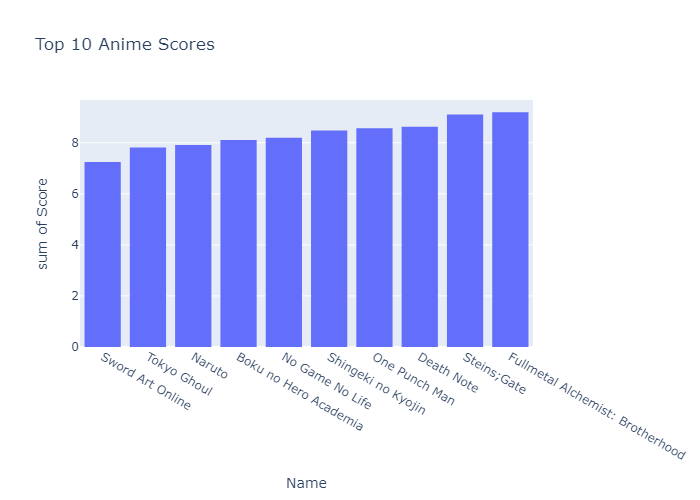

In [13]:
fig = px.histogram(popularity, x ='Name', y='Score', title='Top 10 Anime Scores').update_xaxes(categoryorder='total ascending')
fig.show("png")

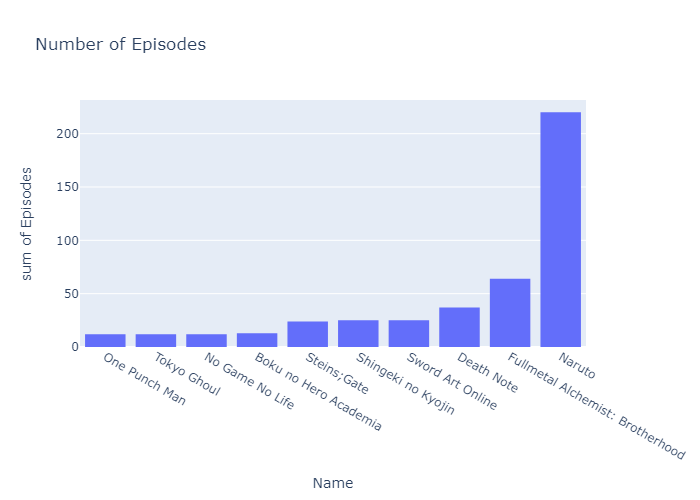

In [14]:
fig = px.histogram(popularity, x='Name', y = 'Episodes', title='Number of Episodes').update_xaxes(categoryorder='total ascending')
fig.show("png")

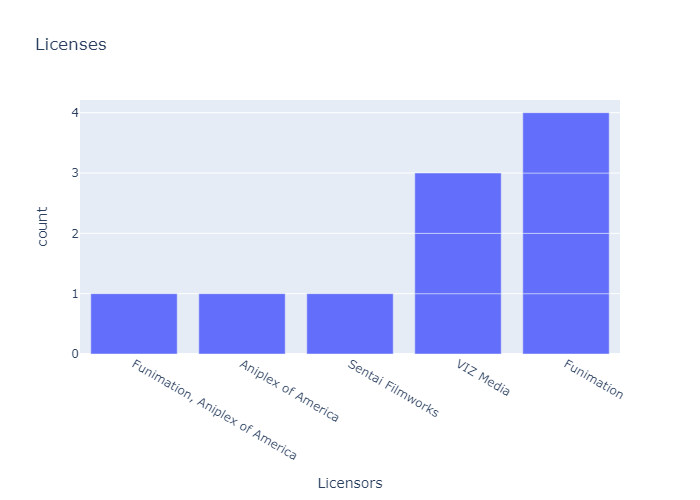

In [15]:
fig = px.bar(popularity, x='Licensors', title='Licenses').update_xaxes(categoryorder='total ascending')
fig.show("png")

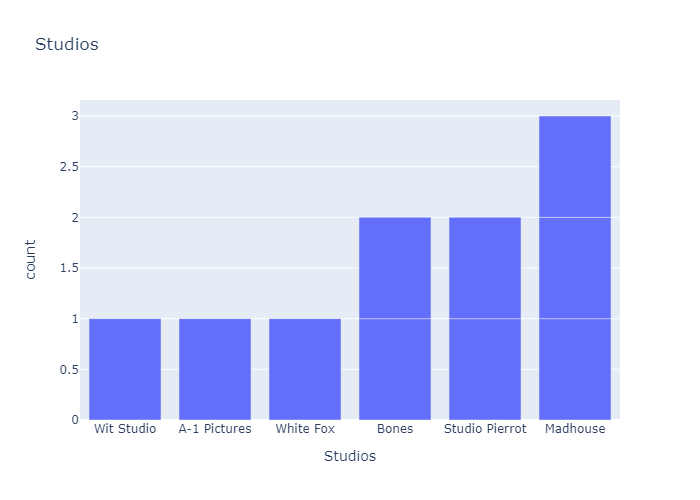

In [16]:
fig = px.bar(popularity, x='Studios', title='Studios').update_xaxes(categoryorder='total ascending')
fig.show("png")

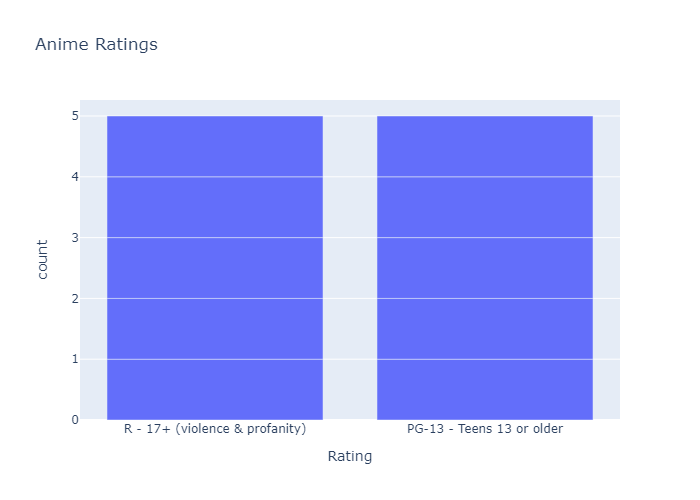

In [17]:
fig = px.bar(popularity, x='Rating', title="Anime Ratings").update_xaxes(categoryorder='total ascending')
fig.show("png")

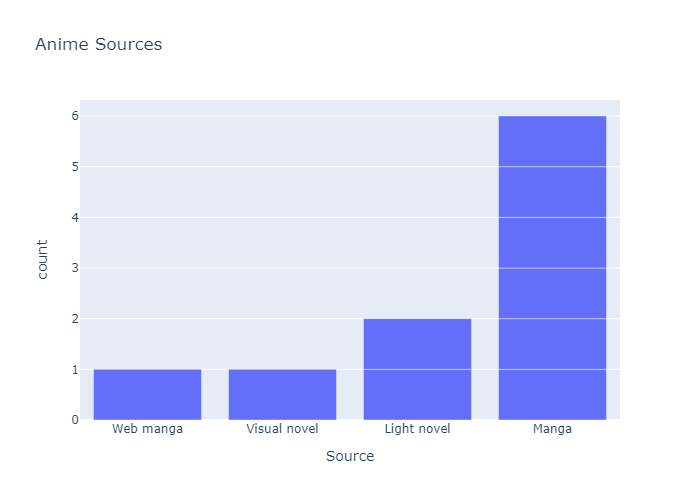

In [18]:
fig = px.bar(popularity, x='Source', title='Anime Sources').update_xaxes(categoryorder='total ascending')
fig.show("png")

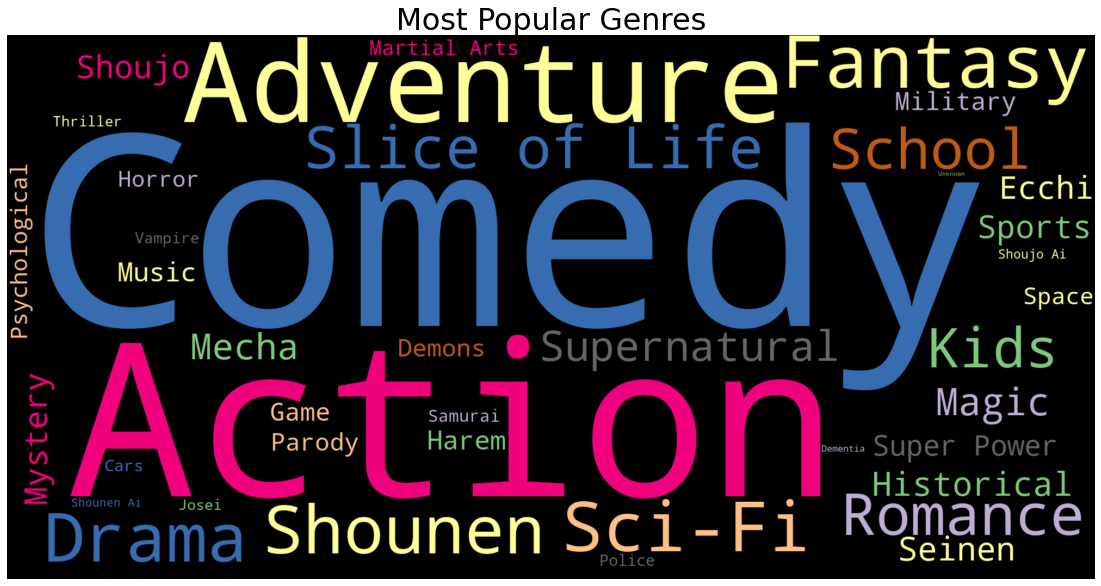

In [19]:
anime_data1 = full_anime_data.copy()

all_genres = defaultdict(int)

for genres in anime_data1['Genres']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

genres_cloud = WordCloud(width=2000, height=1000, background_color='black', colormap='Accent').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Popular Genres',fontsize = 30)
plt.show("png");

In [20]:
def convert(words):
    
    new_words = words.split(',')
    
    return new_words

In [21]:
full_anime_data['Genres'] = full_anime_data['Genres'].apply(convert)
full_anime_data['Aired'] = full_anime_data['Aired'].apply(convert)
full_anime_data['Premiered'] = full_anime_data['Premiered'].apply(convert)
full_anime_data['Producers'] = full_anime_data['Producers'].apply(convert)
full_anime_data['Licensors'] = full_anime_data['Licensors'].apply(convert)
full_anime_data['Studios'] = full_anime_data['Studios'].apply(convert)
full_anime_data['Source'] = full_anime_data['Source'].apply(convert)
full_anime_data['Duration'] = full_anime_data['Duration'].apply(convert)
full_anime_data['Rating'] = full_anime_data['Rating'].apply(convert)
full_anime_data['Synopsis'] = full_anime_data['Synopsis'].astype(str).apply(convert)

full_anime_data['tags'] = full_anime_data['Genres'] + full_anime_data['Aired'] + full_anime_data['Premiered'] + full_anime_data['Producers'] + full_anime_data['Licensors'] + full_anime_data['Studios'] + full_anime_data['Source'] + full_anime_data['Duration'] + full_anime_data['Rating'] + full_anime_data['Synopsis']

In [22]:
new_data = full_anime_data[['MAL_ID', 'Name', 'tags']]

In [23]:
new_data['tags'] = new_data['tags'].apply(lambda x: " ".join(x))
new_data['tags'] = new_data['tags'].apply(lambda x: x.lower())

In [24]:
# new_data.head()

In [25]:
ps = PorterStemmer()

def stem(text):
    y = []
    
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)

In [26]:
new_data['tags'] = new_data['tags'].apply(stem)

In [27]:
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
stop_words = nltk.corpus.stopwords.words('english')
gensim_sw = STOPWORDS
sklearn_sw = ENGLISH_STOP_WORDS

stop_words.extend(sw_spacy)
stop_words.extend(gensim_sw)
stop_words.extend(sklearn_sw)
stop_words = set(stop_words)

In [28]:
tfidf = TfidfVectorizer(max_features=5000, stop_words=stop_words)

In [29]:
vectors = tfidf.fit_transform(new_data['tags']).toarray()

In [30]:
similarity = cosine_similarity(vectors)

In [31]:
def recommend(anime):
    anime_index = new_data[new_data['Name'] == anime].index[0]
    distances = similarity[anime_index]
    animes_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:6]
    
    for i in animes_list:
        print(new_data.iloc[i[0]].Name)

In [32]:
recommend('Trigun')

Lodoss-tou Senki: Eiyuu Kishi Den
Only You: Viva! Cabaret Club
DT Eightron
El Hazard: The Alternative World
Yume de Aetara (TV)


In [33]:
new_data.iloc[3827].Name

'Boruto: Naruto Next Generations'

In [34]:
pickle.dump(new_data, open('animes.pkl', 'wb'))

In [35]:
pickle.dump(new_data.to_dict(), open('animes_dict.pkl', 'wb'))

In [36]:
pickle.dump(similarity, open('similarity.pkl', 'wb'))